In [1]:
# Standard libraries
import numpy as np
import json
from datetime import datetime

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.random import random_circuit

# Own library
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, AlternativeCircuit, Circuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend




In [2]:
IBM_TOKEN = "token"

In [3]:
provider = IBMProvider(token=IBM_TOKEN)
backend = provider.get_backend('ibm_brisbane')
prop = backend.properties()

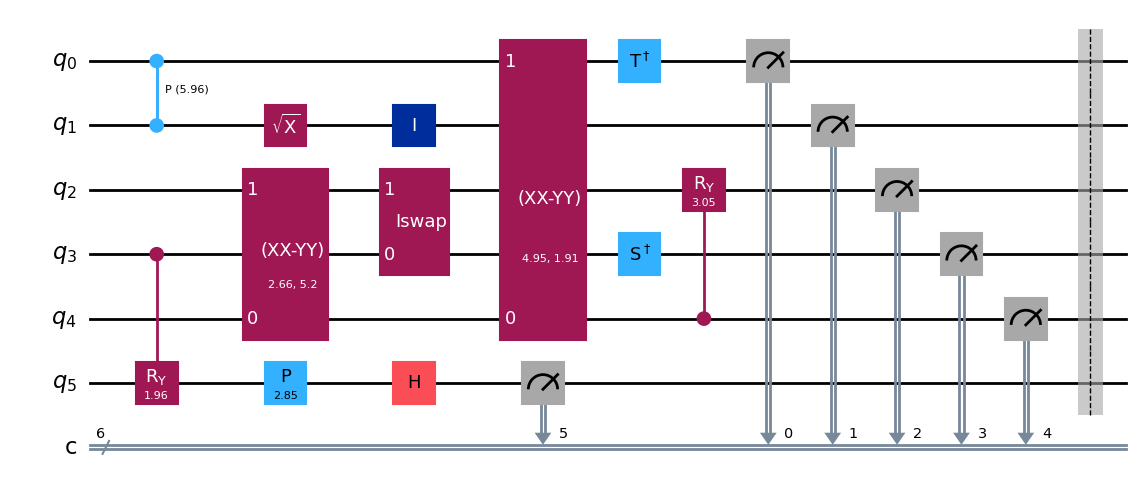

In [5]:
N_QUBIT = 6
N_BIT = N_QUBIT


circ = random_circuit(N_QUBIT, 3, seed = 1, measure=True)

"""
circ.rz(np.pi/2, 1)
circ.rz(-np.pi/2, 0)

circ.sx(0)
circ.sx(1)

circ.rz(np.pi/2, 0)
circ.rz(-np.pi/2, 1)

circ.ecr(1,0)


circ.rz(np.pi/2,1)
circ.rz(np.pi/2,0)

circ.sx(0)
circ.sx(1)

circ.rz(np.pi/2,1)
circ.rz(np.pi/2,0)
"""



circ.barrier(range(N_QUBIT))
#circ.measure(range(N_QUBIT),range(N_QUBIT))
circ.draw('mpl')

In [6]:
config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": "ibmq_manila"
    },
    "run": {
        "shots": 1000,
        "qubits_layout": [0,1,2,3],
        #"psi0": [1, 0, 0, 0]
        "psi0": [1, 0, 0, 0]
    }
}



run_config = config["run"]
#qubits_layout = run_config["qubits_layout"]
qubits_layout = list(range(N_QUBIT))
print(qubits_layout)

device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()

[0, 1, 2, 3, 4, 5]


BackendPropertyError: 'Could not find the desired property for ecr'

In [93]:
device_param_lookup['t_ecr']

array([[0.0e+00, 6.6e-07, 0.0e+00, 0.0e+00, 0.0e+00],
       [6.6e-07, 0.0e+00, 6.6e-07, 0.0e+00, 0.0e+00],
       [0.0e+00, 6.6e-07, 0.0e+00, 6.6e-07, 0.0e+00],
       [0.0e+00, 0.0e+00, 6.6e-07, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 6.6e-07, 0.0e+00]])

In [90]:
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= True)

t_circ = transpile(
    circ,
    backend,
    scheduling_method='asap',
    initial_layout=qubits_layout,
    seed_transpiler=42
)

#t_circ.draw(output='mpl')

We only support a linear connectivity at the moment.
Our CPU count is 8
Use 80% of the cores, so 6 processes.
As we perform 1000 shots, we use a chunksize of 167.


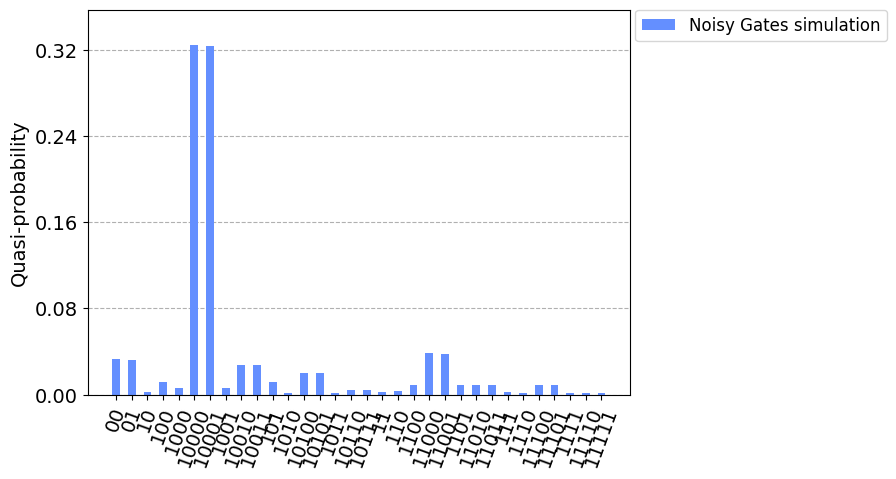

In [91]:
psi0 = [1] + [0] * (2**N_QUBIT-1)

probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(psi0), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=N_QUBIT)

counts_ng = {format(i, 'b').zfill(2): probs[i] for i in range(0, 2**N_QUBIT)}

plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

In [62]:
n_rz, swap_detector, data = sim._preprocess_circuit(t_circ, qubits_layout, N_QUBIT)

In [63]:
data[0][1][1]._index

IndexError: list index out of range

In [12]:
prob = sim._perform_simulation(1000, data, n_rz, N_QUBIT, device_param_lookup, [1, 0, 0, 0])


In [11]:
prob

array([0.01518851, 0.0149353 , 0.48625159, 0.48331169])

In [13]:
reordered_probs = sim._fix_probabilities(prob, swap_detector, N_QUBIT)

In [14]:
reordered_probs

[0.015077917903775603,
 0.48530284437060645,
 0.014994390937216478,
 0.48400116458717474]

In [22]:
_apply_gates_on_circuit(data, circ = t_circ, device_param=device_param_lookup)

AttributeError: 'QuantumCircuit' object has no attribute 'nqubit'